[실습 과제]

train.csv 파일로 작성한 분석용 데이터셋에 대하여 DecisionTreeClassifier를 이용하여 다음을 수행하세요.

- 학습데이터와 검증데이터 분리한 후 정확도 평가
- cv=5를 적용한 KFold 교차 검증 수행 후 정확도 평가
- cv=5를 적용한 cross_val_score 교차검증 수행 후 정확도 평가
- GridSearchCV를 이용해 최적 하이퍼파라미터를 찾고 예측성능 측정하기

In [3]:
#연산
import pandas as pd
import numpy as np

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import classification_report, confusion_matrix
# sklearn.metrics는 scikit-learn 패키지 중 모델 평가에 사용되는 모듈이다.
# sklearn.metrics 패키지의 모듈 중 classification_report는 
# 주요 분류 측정 항목을 보여주는 보고서 모듈이다.
# confusion_matrix는 분류의 정확성을 평가하기 위한 오차행렬 계산 모듈이다.
from sklearn.model_selection import train_test_split
# sklearn.model_section은 scikit-learn 패키지 중 클래스를 나눌 때, 
# 그리고 함수를 통해 train/test셋을 나눌 때, 
# 아울러 모델 검증에 사용되는 서브 패키지 이다.
# sklearn.model_selection 패키지의 모듈중 train_test_split은 
# 배열 또는 행렬을 임의의 훈련 및 테스트 셋으로 분할하는 모듈이다.
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# sklearn.tree는 scikit-learn 패키지 중 
# 분류 및 회귀를 위한 의사결정 트리 기반 모델이있는 서브 패키지 이다.
# sklearn.tree 패키지의 모듈 중 DecisionTreeClassifier는 
# 의사결정 트리 분류 모듈이다.
from IPython.display import Image
import os

In [2]:
tdf = pd.read_csv("dataset/train.csv")
tdf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
tdf.drop(['PassengerId','Ticket','Cabin'], axis = 1, inplace=True)

In [9]:
def name_split(name):
    name = str(name)
    props = name.split(' ')
    if 'Mr.' in props:
        return 'Mr'
    elif 'Mrs.' in props:
        return 'Mrs'
    elif 'Miss.' in props:
        return 'Miss'
    elif 'Master.' in props:
        return 'Master'
    else:
        return ' '
    
tdf.Name = tdf.Name.apply(name_split)
tdf.Name.head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Name, dtype: object

In [10]:
tdf.Name = tdf.Name.map(lambda x : x.replace(' ', 'Mr'))
tdf.Name.value_counts()

Mr        544
Miss      182
Mrs       125
Master     40
Name: Name, dtype: int64

In [11]:
tdf.Embarked = tdf.Embarked.fillna('S')

In [13]:
def fare_cat(fare):
    if fare<8:
        return 3
    elif fare<15:
        return 2
    elif fare<31:
        return 1
    else:
        return 0
    
tdf['Fare_cat'] = tdf.Fare.apply(lambda x:fare_cat(x))
tdf.Fare_cat.head()

0    3
1    0
2    3
3    0
4    2
Name: Fare_cat, dtype: int64

In [14]:
def age_cat(age):
    if age<10:
        return 'Child'
    elif age<20:
        return 'Teen'
    elif age<45:
        return 'Adult'
    elif age<65:
        return 'Mid_Age'
    else:
        return 'Elderly'
    
tdf['Age_Cat'] = tdf.Age.apply(lambda x : age_cat(x))
tdf.Age_Cat.head()

0    Adult
1    Adult
2    Adult
3    Adult
4    Adult
Name: Age_Cat, dtype: object

<AxesSubplot:xlabel='Age_Cat', ylabel='Survived'>

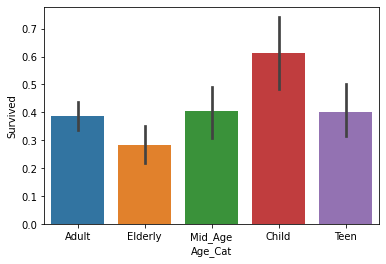

In [15]:
sns.barplot(data=tdf,x='Age_Cat',y='Survived')

In [16]:
Age_Cat_d = pd.get_dummies(tdf.Age_Cat)
Emb_d = pd.get_dummies(tdf.Embarked)
Name_d = pd.get_dummies(tdf.Name)
Sex_d = pd.get_dummies(tdf.Sex)

In [19]:
tdf['Family'] = tdf.SibSp + tdf.Parch

In [20]:
tdf1 = tdf[['Survived','Fare_cat','Family']]
tdf1 = pd.concat([tdf1,Age_Cat_d, Emb_d,Name_d,Sex_d],axis=1)
tdf1

,Survived,Fare_cat,Family,Adult,Child,Elderly,Mid_Age,Teen,C,Q,S,Master,Miss,Mr,Mrs,female,male
0,0,3,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1
1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0
2,1,3,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0
4,0,2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
887,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
888,0,1,3,0,0,1,0,0,0,0,1,0,1,0,0,1,0
889,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1


In [25]:
y_tdf = tdf1['Survived']
X_tdf = tdf1.drop('Survived',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_tdf,y_tdf,test_size=0.2,random_state=11)

In [26]:
dt_clf = DecisionTreeClassifier()

In [27]:
# 문제점:
# 학습용 데이터에서는 정확도가 높지만,
# 검증용 데이터에서 정확도가 낮아지면 일반화된 모델이라고 할 수 없다.
# 맞을 때까지 도가 지나치게 돌리면 과적화될 수 있음.
# 그런 문제를 해결하고자 교차검증 수행
dt_clf.fit(X_train, y_train)

# 학습용 데이터와 검증 데이터를 하나씩만 나누는 게 아니라,
# 전체 데이터를 k개만큼 나눈다.
# k1그룹 평가결과 ~ k5평가결과 등 
# 5그룹 데이터를 모두 평가한 후 평균을 내서 교차검증할 수 있다.

DecisionTreeClassifier()

In [28]:
dt_prediction = dt_clf.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score

In [31]:
print('dt 정확도:{0:.4f}'.format(accuracy_score(y_test,dt_prediction)))

dt 정확도:0.8380


[과제] dt_clf 대신 random forest를 이용해서 아래의 과정을 수행해 보기

- 학습데이터와 검증데이터 분리한 후 정확도 평가
- cv=5를 적용한 KFold 교차 검증 수행 후 정확도 평가
- cv=5를 적용한 cross_val_score 교차검증 수행 후 정확도 평가
- GridSearchCV를 이용해 최적 하이퍼파라미터를 찾고 예측성능 측정하기

In [32]:
from sklearn.model_selection import KFold
def exec_kfold(clf,folds=5):
    # Fold 세트 5개인 KFold 객체 생성
    # Fold 수만큼 예측 결과 저장을 위한 리스트 생성
    kfold = KFold(n_splits=folds)
    scores = []
    # KFold 교차검증 수행                       enumerate는 index가 함꼐 나옴
    for iter_count, (train_index, test_index) in enumerate(kfold.split(tdf)):
        X_train, X_test = X_tdf.values[train_index],X_tdf.values[test_index]
        y_train, y_test = y_tdf.values[train_index],y_tdf.values[test_index]
        
        # Classifier 학습, 예측 정확도 계산
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test,pred)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count,accuracy))
    # 5eo fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도:{0:.4f}".format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7765
교차 검증 1 정확도: 0.8146
교차 검증 2 정확도: 0.7697
교차 검증 3 정확도: 0.7472
교차 검증 4 정확도: 0.8146
평균 정확도:0.7845


In [33]:
from sklearn.model_selection import GridSearchCV
# max_depth : 의사결정나무를 얼마나 수행할 것인지 최대치를 정해 줌
# min_sample_split : 분기될 때 최소한의 샘플 수
# min_samples_leaf : 이 leaf는 의사결정나무의 잎사귀를 말하는 것이다.
parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5],'min_samples_leaf':[1,5,8]}
# cv는 교차검증 k의 갯수 - cross validation의 약자.
# dt_clf 자리에 random forest나 로지스틱regression 등을 넣어서 검증을 할 수 있다.

# dt_clf = DecisionTreeClassifier()

# [과제] - random forest를 이용해서 이를 구해 보기

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy',cv=5)
# 이것을 가지고 학습한다.
grid_dclf.fit(X_train,y_train)
print('GCV 최적 하이퍼 파라미터:',grid_dclf.best_params_)
print('GCV 최고 정확도:{0:.4f}'.format(grid_dclf.best_score_))
# best_estimator:best params가 적용된  estimator이다.
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
# GridSearchCV는 일반화를 하기 위한 최적의 parameter 값을 알려주고
# 이를 종합해서 grid search cv 객체를 만들어 준다.
# 이 객체로 학습을 시키고, 만든 best_dclf로 예측을 해서
# 검증용으로 남겨 둔 실제 데이터와 비교해서 정확도를 구한다.

dpred = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpred)
print('GCV에 의한 DT 정확도:{0:.4f}'.format(accuracy))

GCV 최적 하이퍼 파라미터: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
GCV 최고 정확도:0.8174
GCV에 의한 DT 정확도:0.8659
